In [3]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from functools import partial

import scipy.stats as st
from scipy import optimize as opt

In [4]:
# Import tools file
from gerrymandering_tools import *

# TL;DR
This notebook contains code that does the following:
- Generate plots for
    - Seats/Votes curves (including specific congressional data)
    - Declination
    - Expected Seats won (both Beta and Normal formulations), including an analysis of the variance parameter
    - Computing the distribution of these measures in a small ensemble 
- Compute
    - Expected Seats won

# Congressional District Data

In this section, I import a file of generic congressional district partisan data based on 2012 and 2016 presidential election results. 

In [5]:
# Read in the congressional district data
margin_data = pd.read_csv("UtahData/data-5vPn3.csv")

# Add a column to the data containing the Democrat vote percentage
margin_data["Rep %"] = (margin_data["Trump %"] + margin_data["Romney %"])/(margin_data["Clinton %"] + margin_data["Obama %"] + margin_data["Trump %"] + margin_data["Romney %"])

In [6]:
# An example
margin_data.loc[343]

Dist                    RI-02
Incumbent    Jim Langevin (D)
PVI                       D+6
Clinton %                49.9
Trump %                  43.1
Obama %                  59.7
Romney %                 38.1
Rep %                0.425577
Name: 343, dtype: object

In [7]:
# Get a sorted list of states
states = sorted(list(set([dist_id[:2] for dist_id in margin_data["Dist"]])))

In [8]:
# Get Utah data
state_data = margin_data[margin_data["Dist"].str.slice(0, 2) == "UT"]
v_utah = np.sort(np.array(state_data["Romney %"]/100))
v_utah

array([0.676, 0.684, 0.775, 0.786])

In [9]:
# North Carolina data (from before redistricting)
nc2014 = np.sort(np.array([0.2662, 0.5127, 0.6781, 0.2403, 0.5704, 0.5652, 0.5935, 0.5535, 0.9390, 0.6102, 0.6290, 0.2465, 0.5731]))
len(nc2014)

13

In [10]:
# How many districts did Republicans win?
s = np.count_nonzero(nc2014 > 1/2)
s

10

# Partisan Symmetry Measures

In [11]:
def generate_seats_votes(v, save=False, savetitle=None):
    """
    Given vote shares v, generate the seats-votes curve.
    
    Parameters:
        v (ndarray): R vote shares in districts
    """
    # The average vote share
    vbar = np.mean(v)
    
    # Use the assumption of uniform partisan swing
    s = np.vectorize(lambda k: np.count_nonzero(v-vbar+k > 1/2))
    
    domain = np.linspace(0, 1, 400)
    
    plt.plot(domain, s(domain), label="Seats-Votes Curve")
    plt.scatter(vbar, s(vbar), label="Actual")
    plt.scatter(1/2, 1/2*len(v), label="Center Point")
    plt.plot((0, 1), (0, len(v)), label="Perfect Proportionality")
    plt.title("Seats-Votes Curve")
    plt.xlabel(r'$k$, Uniform Partisan Swing')
    plt.ylabel(r'$S$, R Seats Won')
    plt.legend(loc="upper left")
    
    if save: plt.savefig(savetitle+'.png')
    plt.show()

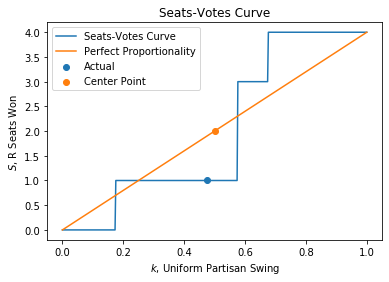

In [12]:
# Generate an example seats-votes curve
generate_seats_votes([0.3, 0.4, 0.4, 0.8], save=False, savetitle="seats_votes1")

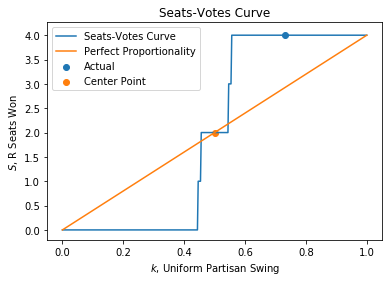

In [13]:
# Generate Utah's seats-votes curve
generate_seats_votes(v_utah, save=False, savetitle="seats_votes_utah2012")

# Declination

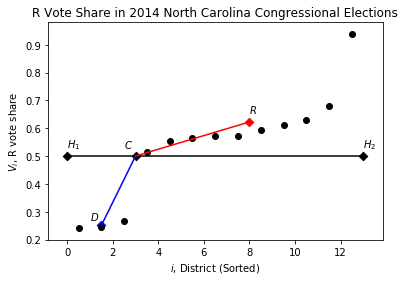

The declination score is -0.5274972219674893.


In [16]:
# Make a plot of the declination for NC 2014

m = len(nc2014)
s = np.count_nonzero(nc2014 > 1/2)
mask_R = np.nonzero(nc2014 > 1/2)
mask_D = np.nonzero(nc2014 < 1/2)
rbar = (1/s)*np.sum(nc2014[mask_R])
dbar = (1/(m-s))*np.sum(nc2014[mask_D])
plt.plot([0, 13], [1/2, 1/2], c="black")

plt.scatter(m*((m-s)/(2*m)), dbar, c="blue", marker="D")
plt.scatter(m*((m-s)/m), 1/2, c="black", marker="D")
plt.scatter(m*((2*m-s)/(2*m)), rbar, c="red", marker="D")
plt.plot([m*((m-s)/(2*m)), m*((m-s)/m)], [dbar, 1/2], c="blue")
plt.plot([m*((m-s)/m), m*((2*m-s)/(2*m))], [1/2, rbar], c="red")
plt.scatter(1/2 + np.arange(m), nc2014, c="black")
plt.xlabel(r"$i$, District (Sorted)")
plt.ylabel(r"$V_i$, R vote share")
plt.title("R Vote Share in 2014 North Carolina Congressional Elections")
plt.text(m*((m-s)/(2*m))-0.5, dbar+0.02, r'$D$')
plt.text(m*((m-s)/m)-0.5, 1/2+0.03, r'$C$')
plt.text(m*((2*m-s)/(2*m)), rbar+0.03, r'$R$')
plt.scatter([0, 13], [1/2, 1/2], c="black", marker="D")
plt.text(0, 1/2+0.03, r'$H_1$')
plt.text(13, 1/2+0.03, r'$H_2$')
# plt.savefig("declination_nc2014.png")
plt.show()

theta_D = np.arctan((1-2*dbar)/((m-s)/m))
theta_R = np.arctan((2*rbar-1)/(s/m))

declination = (2/np.pi)*(theta_R - theta_D)
print("The declination score is {}.".format(declination))

In [15]:
# How many seats (roughly) does this correspond to?
declination*13/2

-3.4287319427886804

# Expected Seats Won

This section explores early formulations of the "expected seats won" concept. 

In [15]:
def total_seats(state):
    """
    Computes the total number of congressional districts in a state.
    
    Parameters:
        state (str): two-letter abbreviation for state
        
    Returns:
        (int): the number of congressional districts
    """
    state_data = margin_data[margin_data["Dist"].str.slice(0, 2) == state]
    return len(state_data)

def seats_proportional(state):
    """
    Computes the number of seats R would win if seats were exactly proportional.
    
    Parameters:
        state (str): two-letter abbreviation for state
    
    Returns:
        (float): the number of seats won
    """
    state_data = margin_data[margin_data["Dist"].str.slice(0, 2) == state]
    return np.sum(state_data["Rep %"])

def expected_seats_won(state):
    """
    An early variant of ESW score.
    
    Parameters:
        state (str): two-letter abbreviation for state
    """
    state_data = margin_data[margin_data["Dist"].str.slice(0, 2) == state]
    return np.sum(st.norm.cdf(19*(state_data["Rep %"]-0.5)))

def gerry_score(state):
    """
    Computes the discrepancy between expected seats won and proportonality.
    
    Parameters:
        state (str): two-letter abbreviation for state
    """
    return (expected_seats_won(state)-seats_proportional(state))/total_seats(state)

In [16]:
# Create series to store statistics
states_ = pd.Series(states, name="State")
seats_count = pd.Series([total_seats(state) for state in states], name = "Total Seats")
seats_pro = pd.Series([seats_proportional(state) for state in states], name = "Proportional Rep Seats")
seats_exp = pd.Series([expected_seats_won(state) for state in states], name = "Expected Rep Seats")
seats_gerry = pd.Series([gerry_score(state) for state in states], name = "Gerry Score")

# Combine the dataframes
states_data = pd.concat([states_, seats_count, seats_pro, seats_exp, seats_gerry], axis=1)
states_data.sort_values("Gerry Score")

C:\Users\Jacob\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Jacob\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Jacob\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


,State,Total Seats,Proportional Rep Seats,Expected Rep Seats,Gerry Score
7,DE,1,0.422521,0.070496,-0.352025
38,RI,2,0.772132,0.080450,-0.345841
45,VT,1,0.332069,0.000710,-0.331360
18,MA,9,3.265595,0.312221,-0.328153
6,CT,5,2.101463,0.562268,-0.307839
10,HI,2,0.607138,0.000207,-0.303466
19,MD,8,2.890935,1.094679,-0.224532
20,ME,2,0.909839,0.570053,-0.169893
31,NM,3,1.365125,0.893271,-0.157285
4,CA,53,18.882493,10.582891,-0.156596


In [17]:
# Look at Alabama's data as an example
state_data = margin_data[margin_data["Dist"].str.slice(0, 2) == "AL"]
state_data

,Dist,Incumbent,PVI,Clinton %,Trump %,Obama %,Romney %,Rep %
0,AL-01,Bradley Byrne (R),R+15,33.8,63.0,37.3,61.7,0.636874
1,AL-02,Martha Roby (R),R+16,32.8,64.5,36.4,62.8,0.647837
2,AL-03,Mike Rogers (R),R+16,31.9,64.8,36.7,62.2,0.649284
3,AL-04,Robert Aderholt (R),R+30,17.3,79.8,23.9,74.7,0.789474
4,AL-05,Mo Brooks (R),R+18,30.9,63.7,34.8,63.7,0.659762
5,AL-06,Gary Palmer (R),R+26,25.8,69.6,24.6,74.3,0.740607
6,AL-07,Terri Sewell (D),D+20,69.5,28.3,72.5,27.0,0.280284


In [18]:
# Print the number of seats in Alabama, number we would expect Dems to win based on proportionality, 
# and the expected number of seats won
total_seats("AL"), seats_proportional("AL"), expected_seats_won("AL")

(7, 4.404122370984819, 5.989392058542708)

In [19]:
# Get the probabilities of Republicans winning the seats in Alabama
st.norm.cdf(19*(state_data["Rep %"]-0.5))

array([9.95347130e-01, 9.97514491e-01, 9.97718743e-01, 9.99999981e-01,
       9.98799210e-01, 9.99997579e-01, 1.49250320e-05])

In [20]:
v_utah

array([0.676, 0.684, 0.775, 0.786])

In [21]:
# Two Variants of the ESW score
esw_normal = lambda s: lambda v: np.sum(st.norm.cdf((v-0.5)/s))
esw_beta = lambda s: lambda v: np.sum(1-st.beta.cdf(0.5, a=-v+v**2*(1-v)/s**2, b=v-1+(1-v)**2*v/s**2))

In [22]:
# FiveThirtyEight observes that districts which are R+5 are won by R 82% of the time

# What is the appropriate scaling parameter?
sn = opt.bisect(lambda s: esw_normal(s)(np.array([0.55])) - 0.82, a=0.01, b=0.1)
sn

0.054623013991949854

In [23]:
# What is the appropriate scaling parameter if we use a beta distribution?
sb = opt.bisect(lambda s: esw_beta(s)(np.array([0.55])) - 0.82, a=0.01, b=0.1)
sb

0.05434328613089748

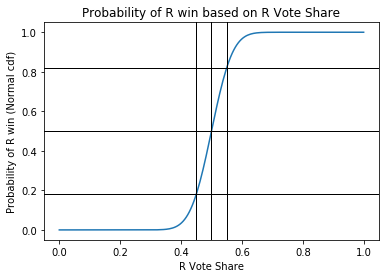

In [24]:
# Plot the normal cdf
domain = np.linspace(0, 1, 200)

plt.plot(domain, [esw_normal(sn)(np.array([d])) for d in domain])
plt.xlabel("R Vote Share")
plt.ylabel("Probability of R win (Normal cdf)")
plt.title("Probability of R win based on R Vote Share")
plt.axhline(0.5, c="black", lw=1)
plt.axhline(0.82, c="black", lw=1)
plt.axhline(0.18, c="black", lw=1)
plt.axvline(0.5, c="black", lw=1)
plt.axvline(0.55, c="black", lw=1)
plt.axvline(0.45, c="black", lw=1)
plt.savefig("normal_dist_empirical.png", dpi=300)
plt.show()

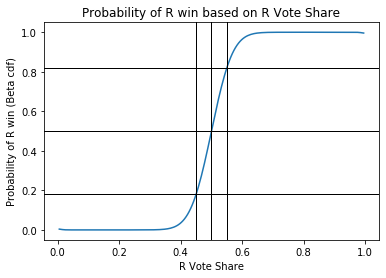

In [25]:
# Plot the Beta cdf
domain = np.linspace(0, 1, 200)

plt.plot(domain, [esw_beta(sb)(np.array([d])) for d in domain])
plt.xlabel("R Vote Share")
plt.ylabel("Probability of R win (Beta cdf)")
plt.title("Probability of R win based on R Vote Share")
plt.axhline(0.5, c="black", lw=1)
plt.axhline(0.82, c="black", lw=1)
plt.axhline(0.18, c="black", lw=1)
plt.axvline(0.5, c="black", lw=1)
plt.axvline(0.55, c="black", lw=1)
plt.axvline(0.45, c="black", lw=1)
plt.savefig("beta_dist_empirical.png", dpi=300)
plt.show()

# GerryChain

In [26]:
# Get the graph data from the file
graph = Graph.from_json("2012_with_buffer_graph-2020-02-18.json")

dist_type = "US_Distric" #'UT_STATE' #"UT_HOUSE" # 
n_steps = 10000      # make this smaller for testing

# the column names aren't quite equal to the graph labels because shapefiles have formatting rules
dist_col = {"US_Distric":"US_District","UT_STATE":"UT_STATE","UT_HOUSE":"UT_HOUSE"}

elections = [ Election("SEN10", {"Dem": "DEM", "Rep": "REP"})]   

my_updaters = {"population": updaters.Tally("POP100", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

# all things that depend on dist_type are mapped here, so we only have to shoose the type above
dist_name = {'US_District':'US Congressional','US_Distric':'US Congressional', 'UT_HOUSE':'UT House', 'UT_STATE':'UT Senate'}
dist_pop_wiggle = {'US_Distric':0.01, 'UT_HOUSE':0.02, 'UT_STATE':0.02}

initial_partition = GeographicPartition(graph, dist_type, updaters=my_updaters)

# set up how much wiggle room is allowed in populations
population_wiggle = dist_pop_wiggle[dist_type]  #don't change the number here--change it in dist_pop_wiggle

# The ReCom proposal needs to know the ideal population for the 
# districts so that it can improve speed by bailing early on 
# unbalanced partitions.
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# Define the population constraint
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 
                                                                population_wiggle)

# Define the "compactness" constraint:
#  this ensures that new districts are roughly the same size as the originals
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2*len(initial_partition["cut_edges"]))

In [27]:
# Define the proposal method
proposal = partial(proposals.recom,
                   pop_col="POP100",
                   pop_target=ideal_population,
                   epsilon=population_wiggle,
                   node_repeats=2)

# Define the chain
chain = MarkovChain(proposal=proposal,
                    constraints=[pop_constraint],
                                #compactness_bound],
                    accept=accept.always_accept,
                    initial_state=initial_partition,
                    total_steps=n_steps)  

In [28]:
# Run the chain (takes 1 hour +)
# data = pd.DataFrame([[mean_median(part['SEN10']),
#                         partisan_bias(part['SEN10']),
#                         efficiency_gap(part['SEN10']),
#                         seats_won(part['SEN10']),
#                         sorted(part["SEN10"].percents("Rep"))] 
#                         for part in tqdm(chain)])
#
# pickle.dump(data, open("5000chain1.pkl", 'wb'))

In [29]:
# Use the pickled chain
with open("5000chain1.pkl", 'rb') as f:
    data = pickle.load(f)

In [30]:
# Set columns
data.columns = ['mean_median','partisan_bias','efficiency_gap',
                'seats_won','percent_rep']

perc_rep = pd.DataFrame(list(data.percent_rep.values))
initial_perc_rep = initial_partition["SEN10"].percents("Rep")

# relabel columns starting at 1, since the official districts are labeled that way
perc_rep.columns = np.arange(len(perc_rep.columns)) + 1

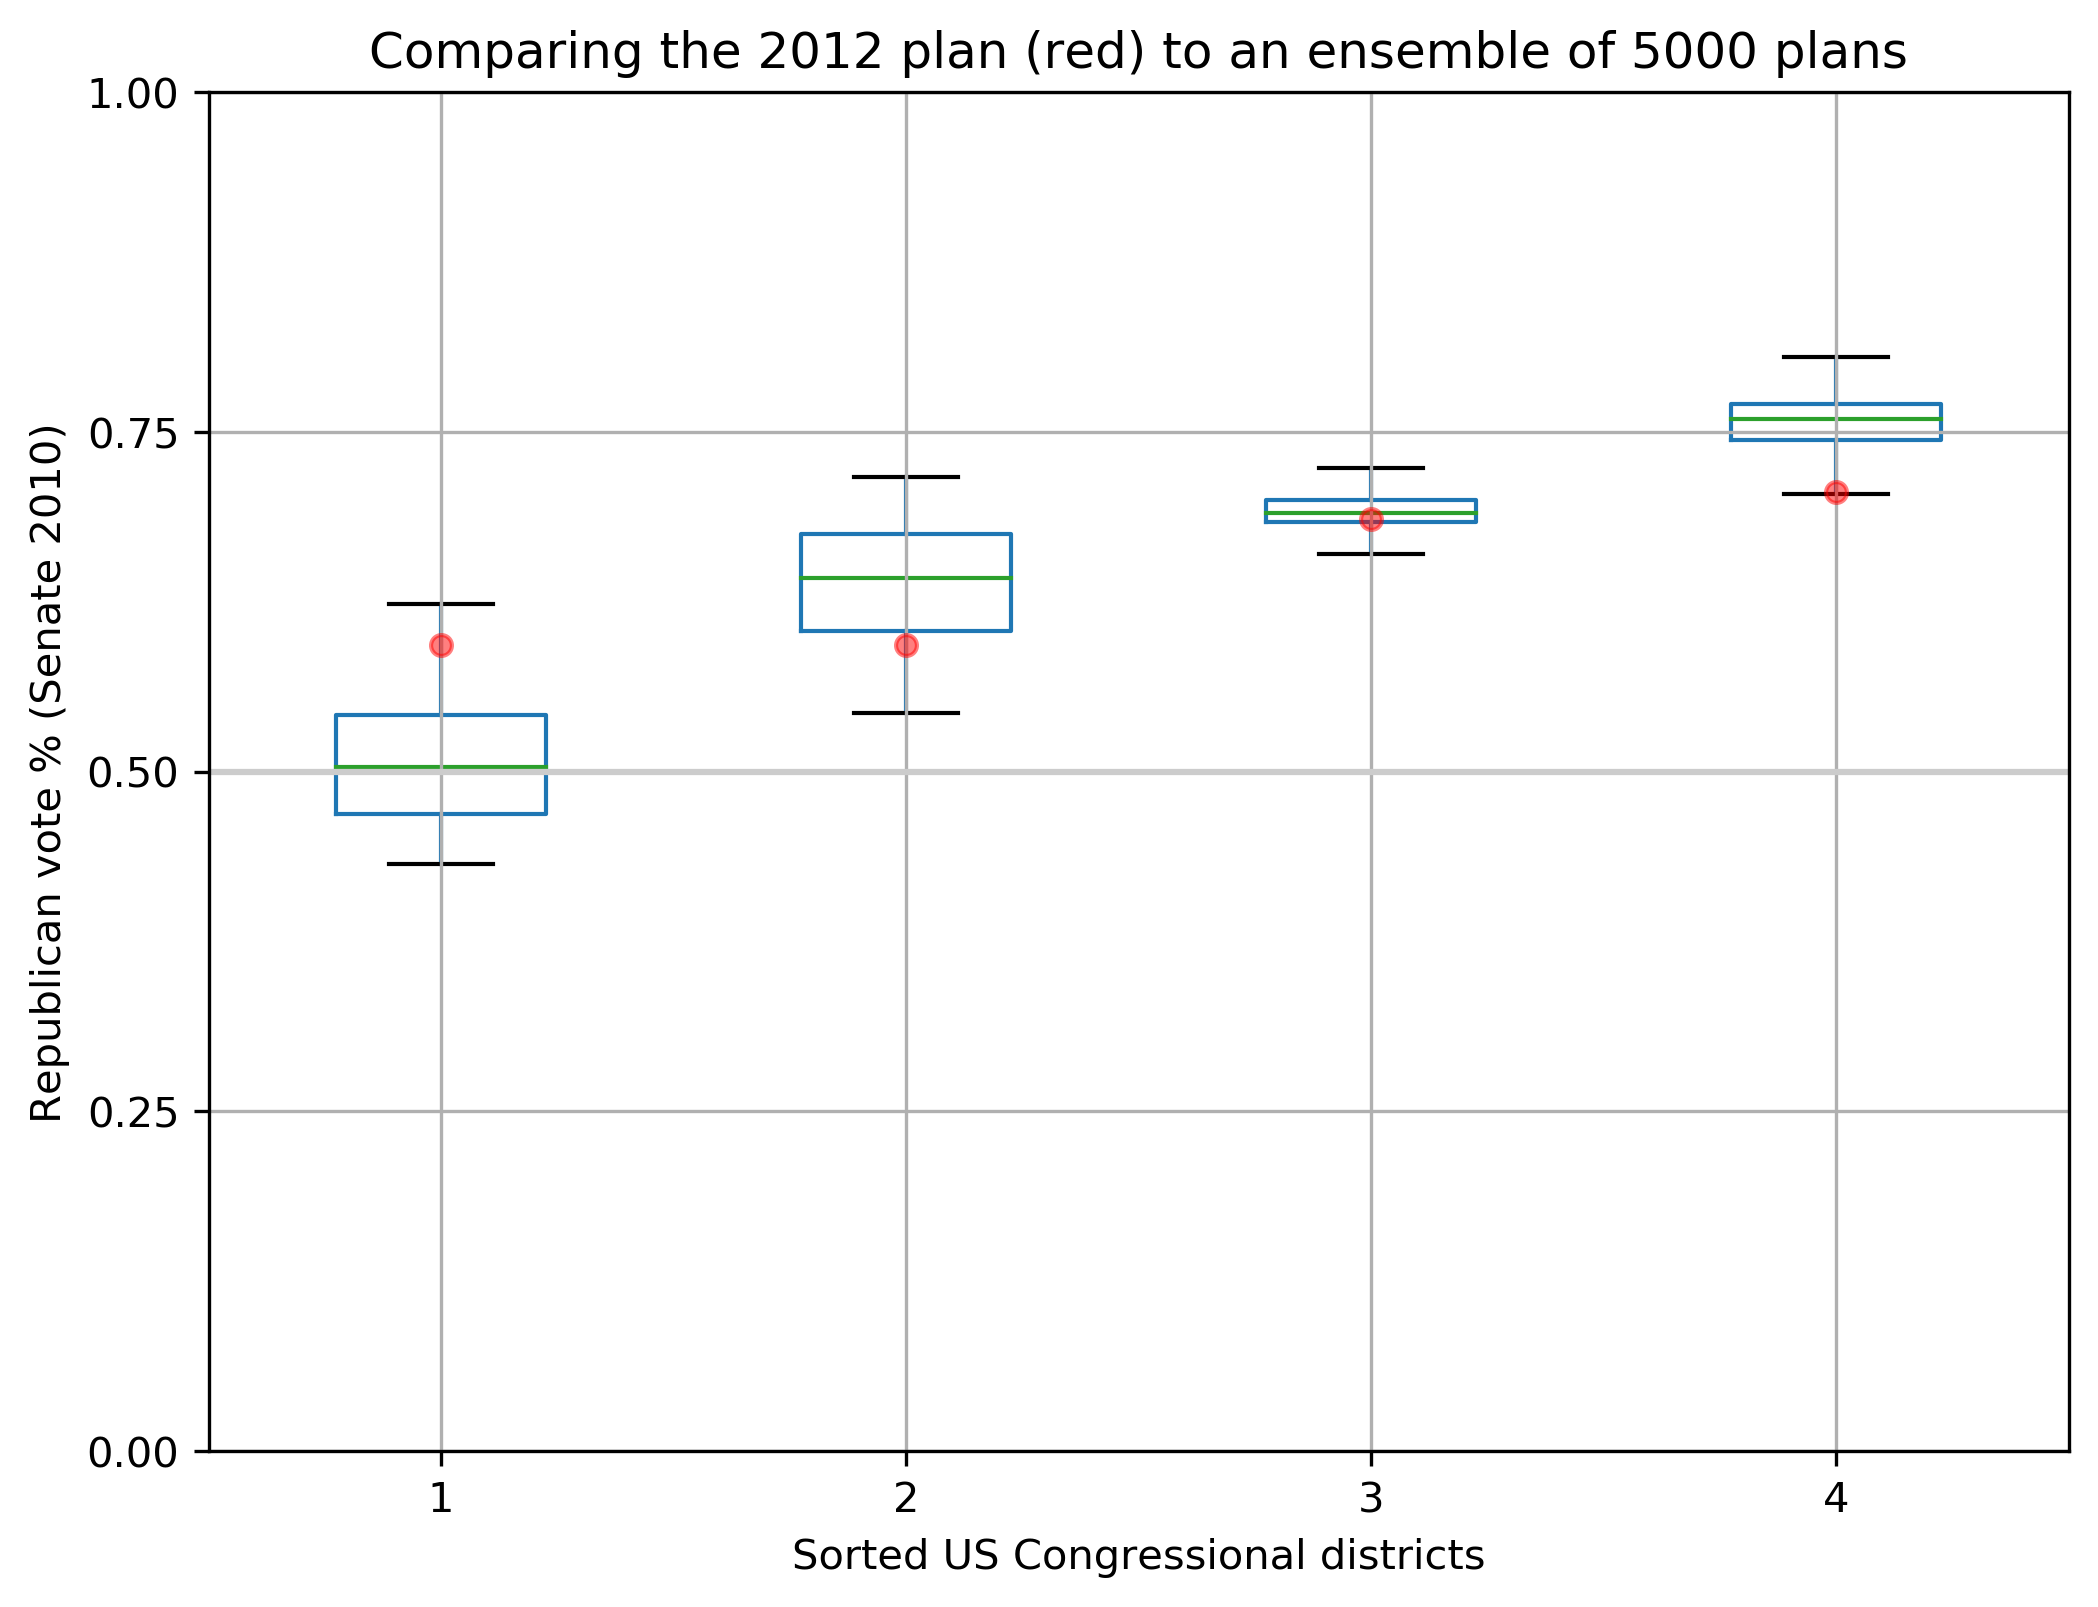

In [31]:
# Make Box Plot
# Plot the percent dems for all the plans, and for the initial plan (red)

fig, ax = plt.subplots(figsize=(8, 6),dpi=300)

# parameter to help make the fig look good
k = max(1, len(perc_rep.iloc[0])//14)


# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot (don't plot outliers)
perc_rep.boxplot(ax=ax, positions=range(1,len(perc_rep.columns)+1),sym='',zorder=1)

# Draw initial plan's Democratic vote percentages (.iloc[0] gives the first row)
ax.scatter(perc_rep.iloc[0].index,perc_rep.iloc[0],color="r",marker="o",s=25/k,alpha=0.5,zorder=5)

# Annotate
ax.set_title("Comparing the 2012 plan (red) to an ensemble of {} plans".format(len(perc_rep)))
ax.set_ylabel("Republican vote % (Senate 2010)")
ax.set_xlabel("Sorted "+dist_name[dist_type]+" districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# Hide enough xlabels to that they don't overlap or look crowded
if k>1:
    for i,label in enumerate(ax.xaxis.get_ticklabels()):
        if i%k:
            label.set_visible(False)
            
plt.savefig("boxplot1.png", dpi=300)

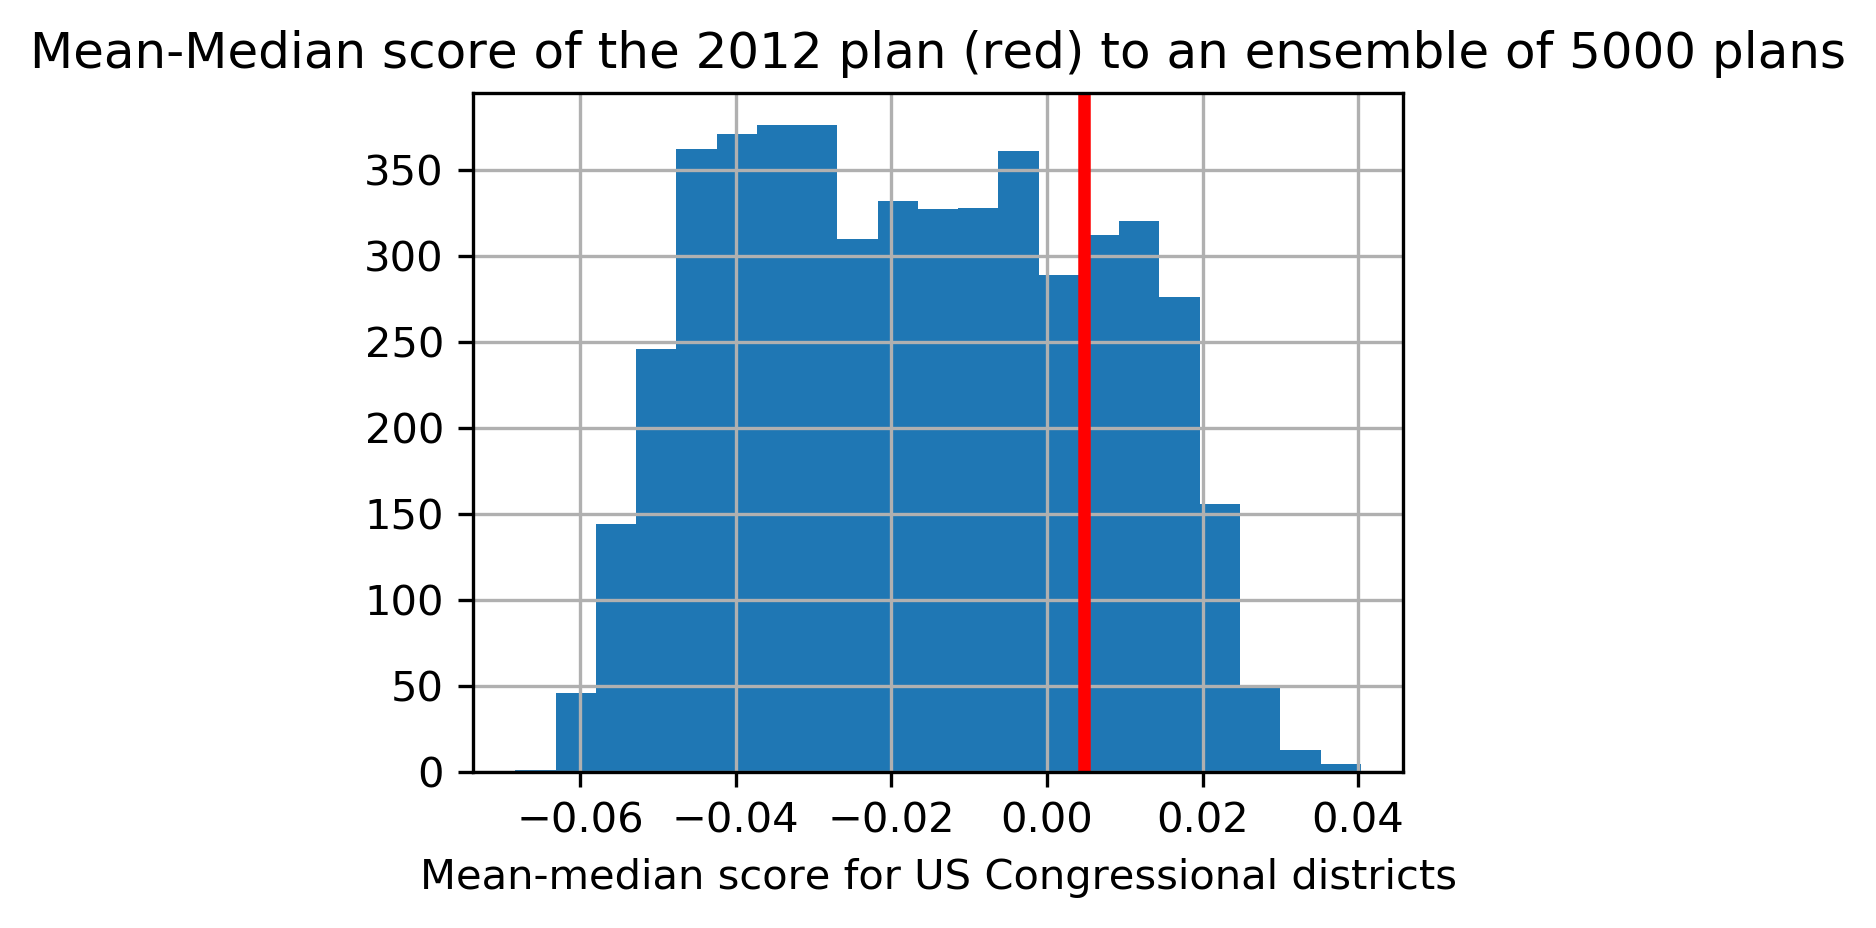

In [32]:
# Plot Mean-Median Distribution

fig, ax = plt.subplots(figsize=(4, 3),dpi=300)

metric = data.mean_median
metric.hist(bins=21)
ax.axvline(x=metric[0], color='r',lw=3)

# Annotate
ax.set_title("Mean-Median score of the 2012 plan (red) to an ensemble of {} plans".format(len(perc_rep)))
ax.set_xlabel("Mean-median score for "+dist_name[dist_type]+" districts")
plt.savefig('mean_median1.png', dpi=300, bbox_inches="tight")

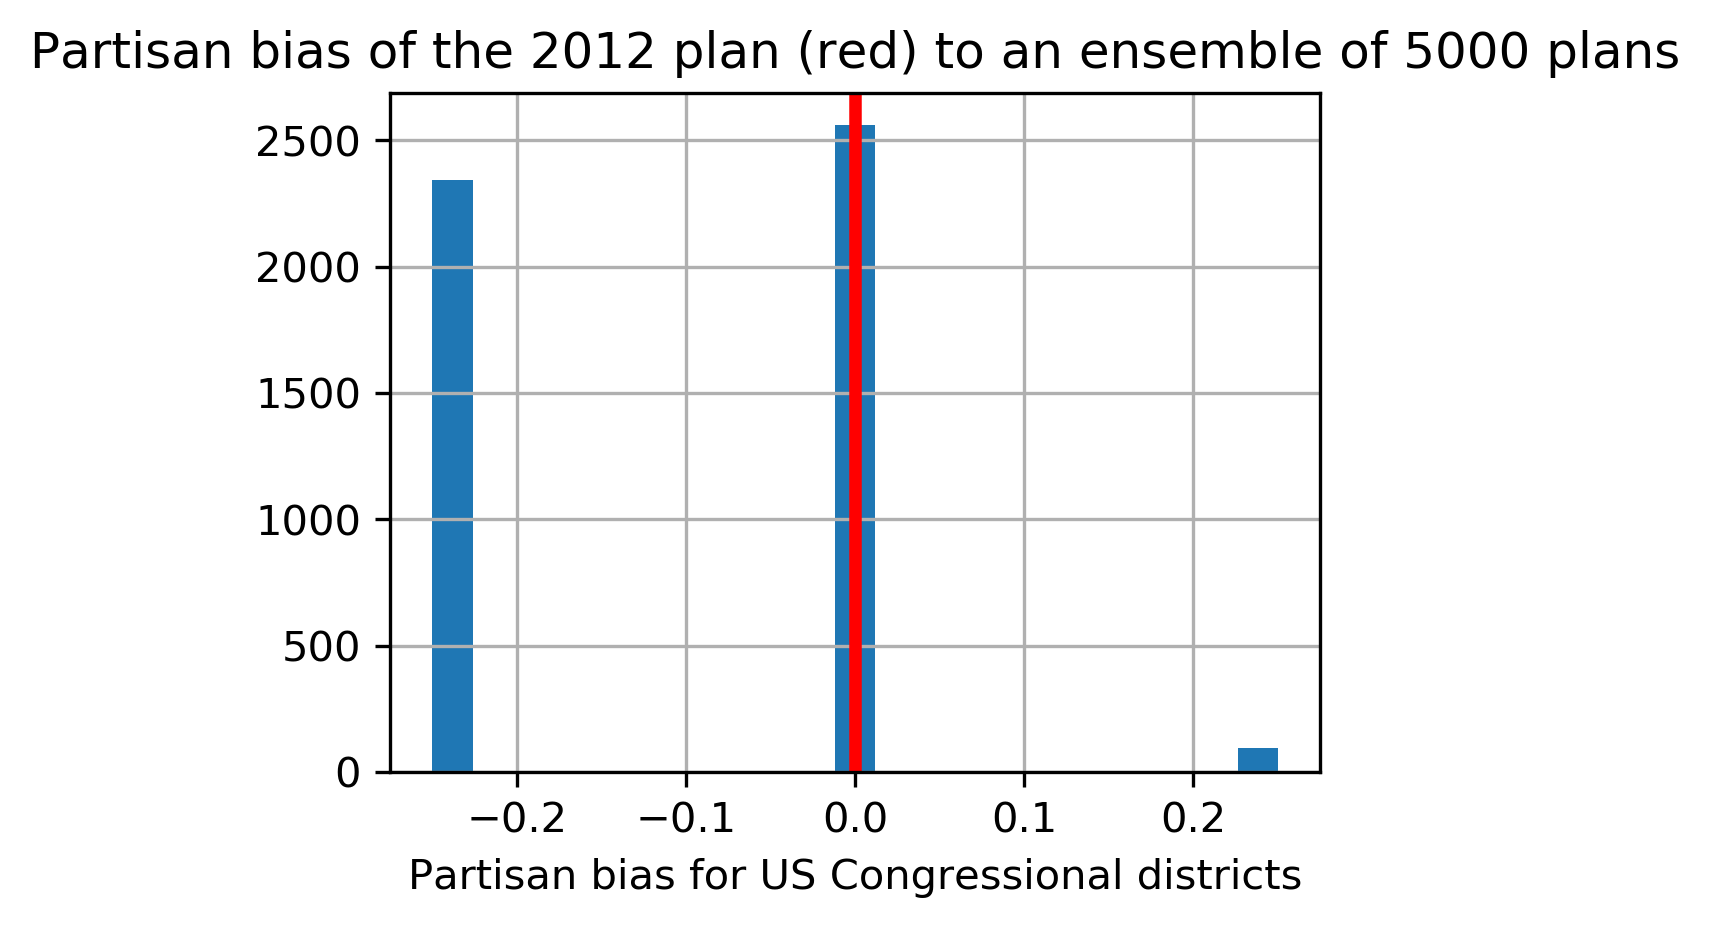

In [33]:
# Plot Partisan Bias distribution
fig, ax = plt.subplots(figsize=(4, 3),dpi=300)

metric = data.partisan_bias
metric.hist(bins=21)
plt.axvline(x=metric[0], color='r',lw=3)

# Annotate
ax.set_title("Partisan bias of the 2012 plan (red) to an ensemble of {} plans".format(len(perc_rep)))
ax.set_xlabel("Partisan bias for "+dist_name[dist_type]+" districts")
plt.savefig('partisan_bias1.png', dpi=300, bbox_inches="tight")

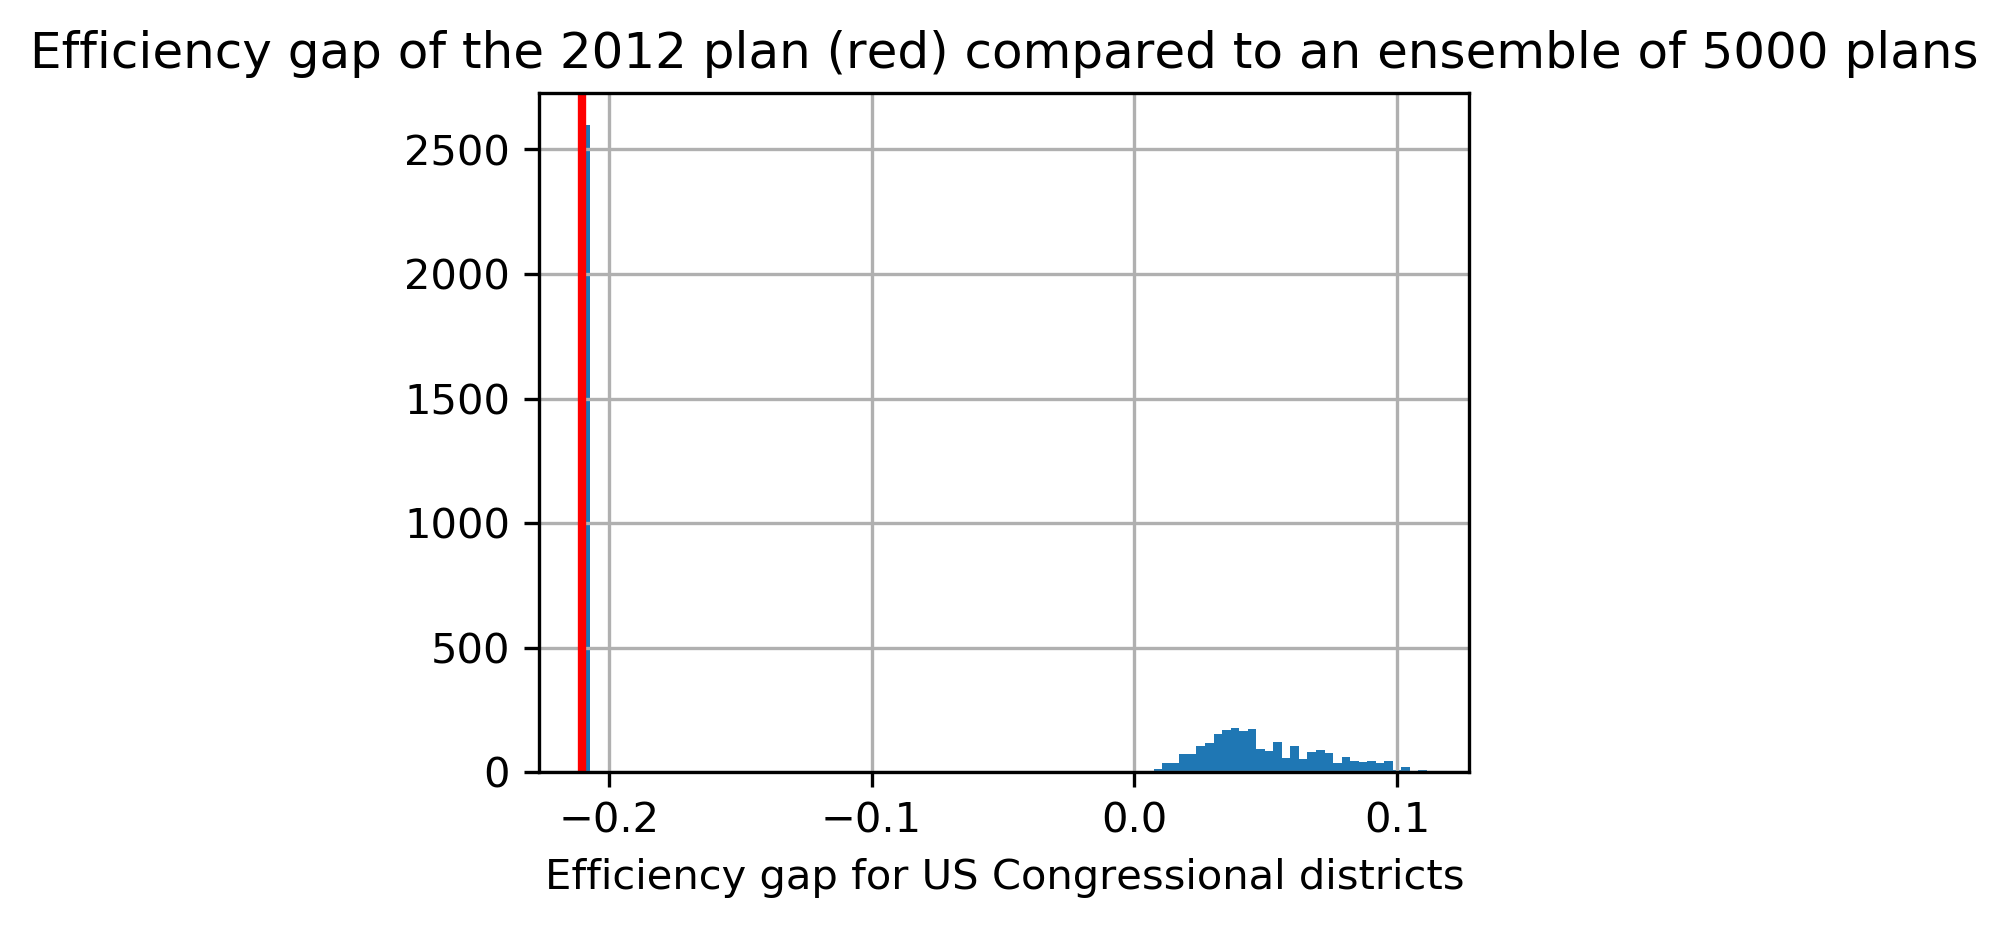

In [34]:
# Plot Efficiency Gap distribution
fig, ax = plt.subplots(figsize=(4, 3),dpi=300)

metric = data.efficiency_gap
metric.hist(bins=99)
ax.axvline(x=metric[0], color='r',lw=2)

# Annotate
ax.set_title("Efficiency gap of the 2012 plan (red) compared to an ensemble of {} plans".format(len(perc_rep)))
ax.set_xlabel("Efficiency gap for "+dist_name[dist_type]+" districts")
plt.savefig('efficiency_gap1.png', dpi=300, bbox_inches="tight")

In [35]:
def calc_percentile(val, data):
    return opt.bisect(lambda x: np.percentile(data, x) - val, 0, 100)

In [36]:
perc_rep.iloc[0]

1    0.593237
2    0.593507
3    0.686235
4    0.705525
Name: 0, dtype: float64

In [37]:
normal_esws = np.array([esw_normal(sn)(perc_rep.iloc[i]) for i in range(len(perc_rep))])

Text(0.5, 0, 'ESW for US Congressional districts')

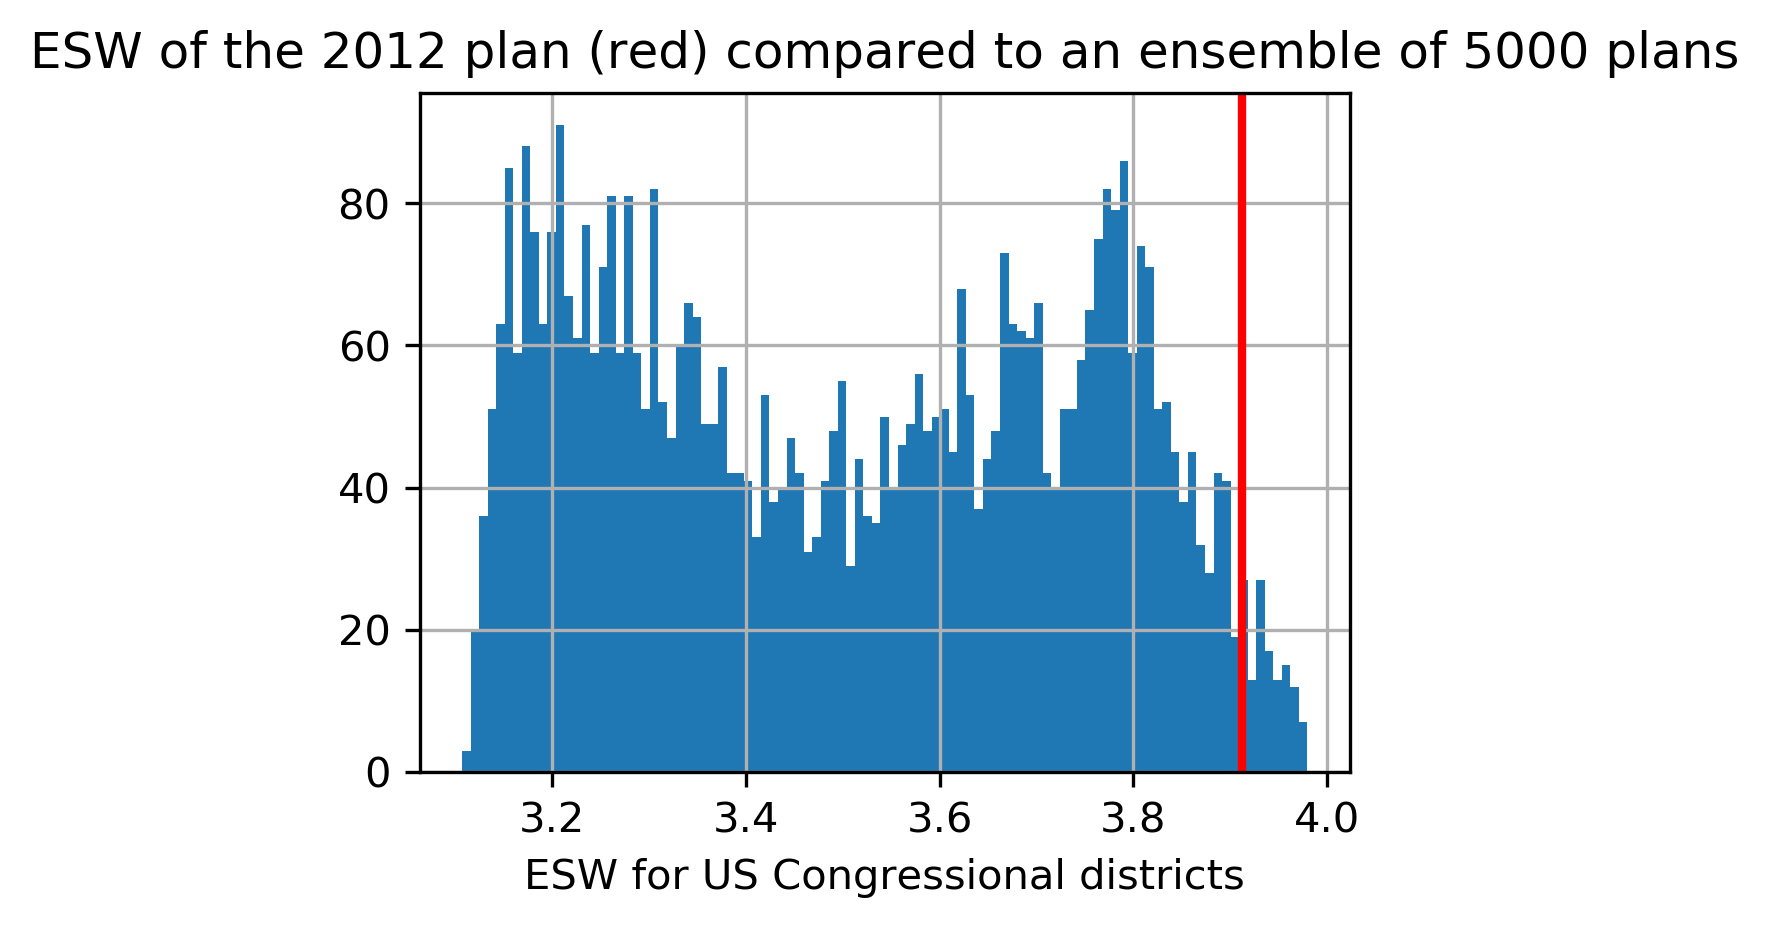

In [38]:
# Plot ESW distribution
fig, ax = plt.subplots(figsize=(4, 3),dpi=300)

metric = pd.Series(normal_esws)
metric.hist(bins=99)
ax.axvline(x=metric[0], color='r',lw=2)

# Annotate
ax.set_title("ESW of the 2012 plan (red) compared to an ensemble of {} plans".format(len(perc_rep)))
ax.set_xlabel("ESW for "+dist_name[dist_type]+" districts")

In [39]:
# What percentage of plans in the ensemble have a lower ESW score?
calc_percentile(normal_esws[0], normal_esws)

97.5995199039815

In [40]:
def probs_to_ss(probs, mode="normal"):
    """
    Converts a list of R win probabilities into standard deviations for use in the ESW score metric.
    
    Parmeters:
        probs (ndarray): An array of R win probabilities in a district with +5% R advantage
        
    Returns:
         ss (ndarray): An array of standard deviations for use in the ESW score metric
    """
    if mode == "normal":
        return np.array([opt.bisect(lambda s: esw_normal(s)(np.array([0.55])) - p, a=1e-7, b=10) for p in probs])
    elif mode == "beta":
        return np.array([opt.bisect(lambda s: esw_beta(s)(np.array([0.55])) - p, a=1e-7, b=10) for p in probs])

def ss_to_probs(ss, mode="normal"):
    """
    Converts ESW standard deviations into a list of R win probabilities at +5% R advantage.
    
    Parmeters:
        ss (ndarray): An array of standard deviations for use in the ESW score metric
    
    Returns:
        probs (ndarray): An array of R win probabilities in a district with +5% R advantage
    """
    if mode == "normal":
        return np.array([esw_normal(s)(np.array([0.55])) for s in ss])
    elif mode == "beta":
        return np.array([esw_beta(s)(np.array([0.55])) for s in ss])

In [41]:
probs_to_ss(np.array([0.65, 0.95]))

array([0.12976212, 0.03039784])

In [42]:
def make_violin_plot_esw(data, probs, mode, save=False, savetitle=None, dpi=300, figsize=(4,3)):
    """
    Make a violin plot of ESW scores
    """
    fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
    
    plt.violinplot(data)
    plt.hlines(y=data[0], xmin = np.arange(len(data))+1-0.2, xmax=np.arange(len(data))+1+0.2, color='r', lw=2)
    plt.title("Expected Seats Won of 2012 plan (red) compared to an Ensemble of 5000 Plans")
    plt.ylabel("ESW ({} Model)".format(mode))
    plt.xticks(ticks=np.arange(len(data))+1, labels = np.round(probs, 2))
    plt.xlabel("Probability of R win in an R+5% District")
    
    for i in range(len(data)):
        plt.text(i+1-0.24, data.iloc[i, 0]-0.07, str(np.round(calc_percentile(data.iloc[i, 0], data.iloc[i]),1))+'%')
        
    if save: plt.savefig(savetitle+'.png', dpi=dpi, bbox_inches='tight')
        
    plt.show()

In [43]:
# Make a violin plot for the normal distribution ESW
probs = 0.01*np.arange(65, 100, 5)

# Takes long (45 s)
# esws1 = pd.DataFrame([[esw_normal(s)(perc_rep.iloc[i]) for i in range(len(perc_rep))] for s in probs_to_ss(probs)])

# Use instead:
esws1 = pickle.load(open("esws1.pkl", 'rb'))

In [44]:
# pickle.dump(esws1, open("esws1.pkl", 'wb'))

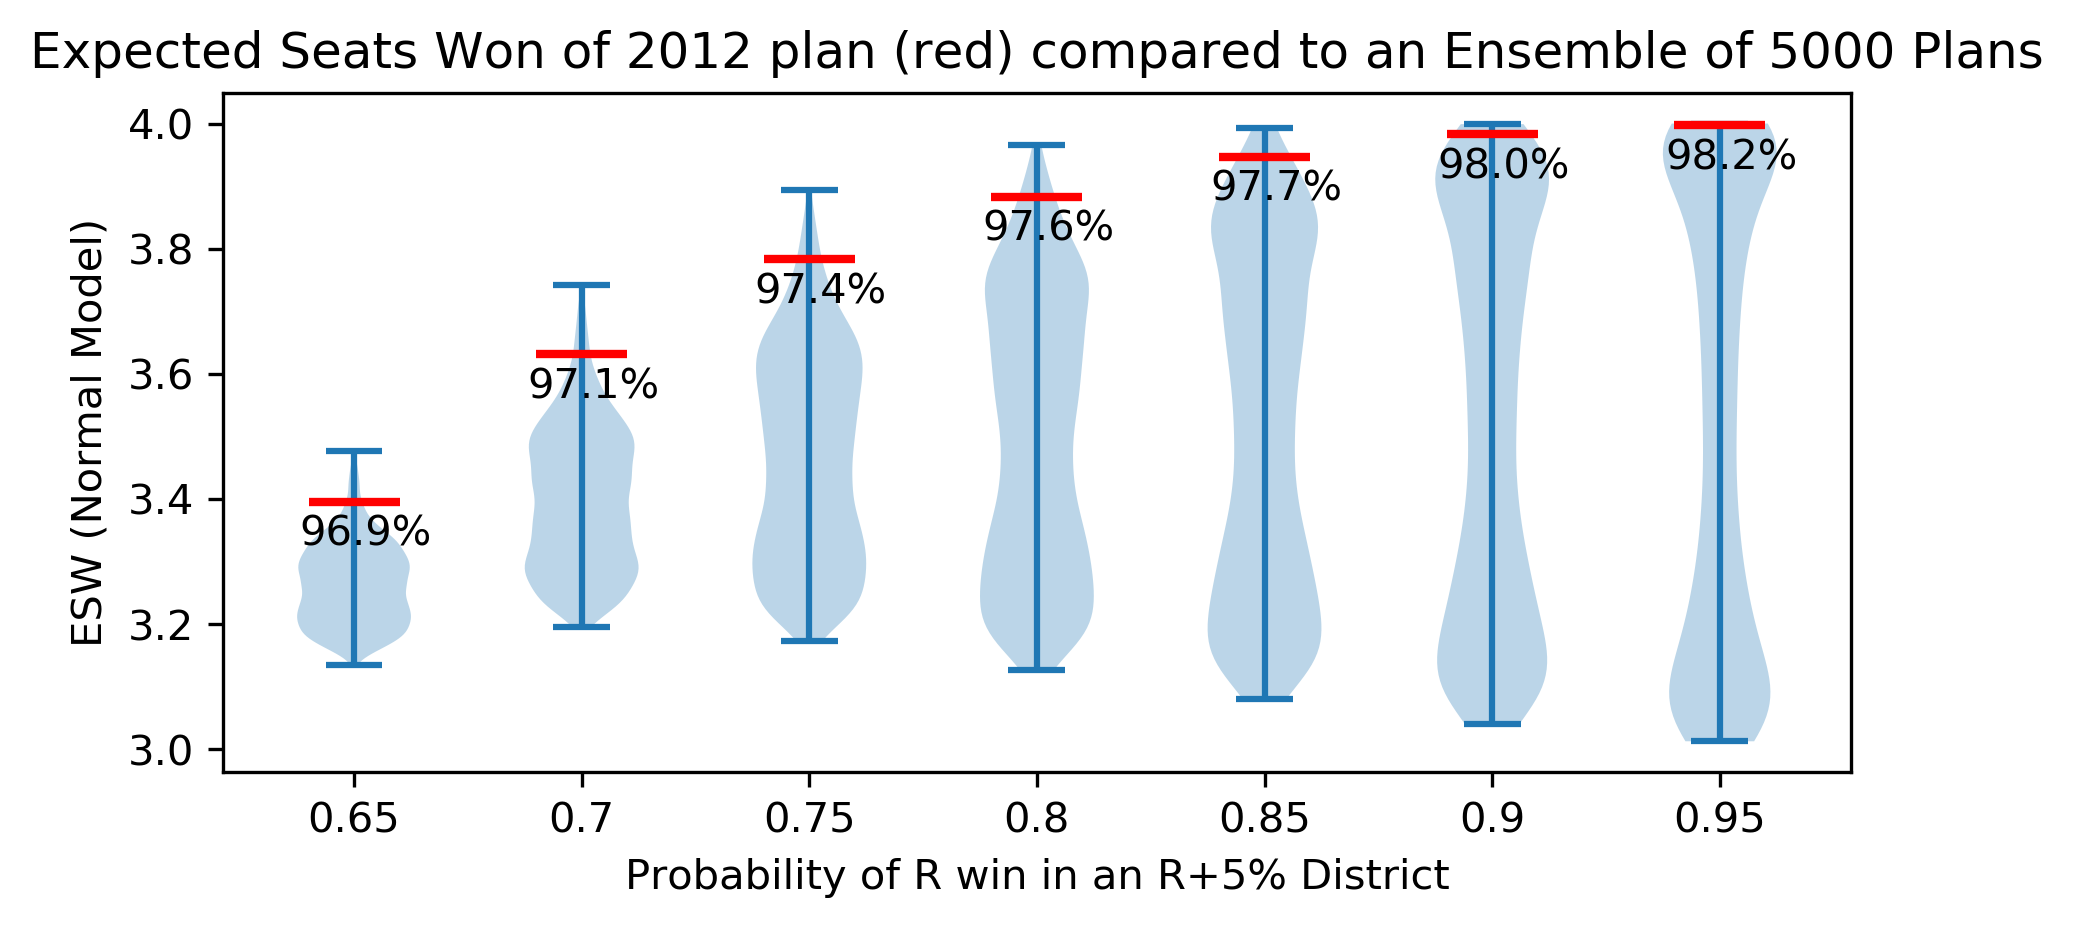

In [45]:
make_violin_plot_esw(esws1, probs, mode="Normal", figsize=(7,3), save=True, savetitle="esw_normal_1")

In [46]:
# Make a violin plot for the normal distribution ESW
probs2 = 0.01*np.arange(76, 90, 2)

# Takes long (45 s)
# esws2 = pd.DataFrame([[esw_normal(s)(perc_rep.iloc[i]) for i in range(len(perc_rep))] for s in probs_to_ss(probs2)])

# Use instead:
esws2 = pickle.load(open("esws2.pkl", 'rb'))

In [47]:
# pickle.dump(esws2, open("esws2.pkl", 'wb'))

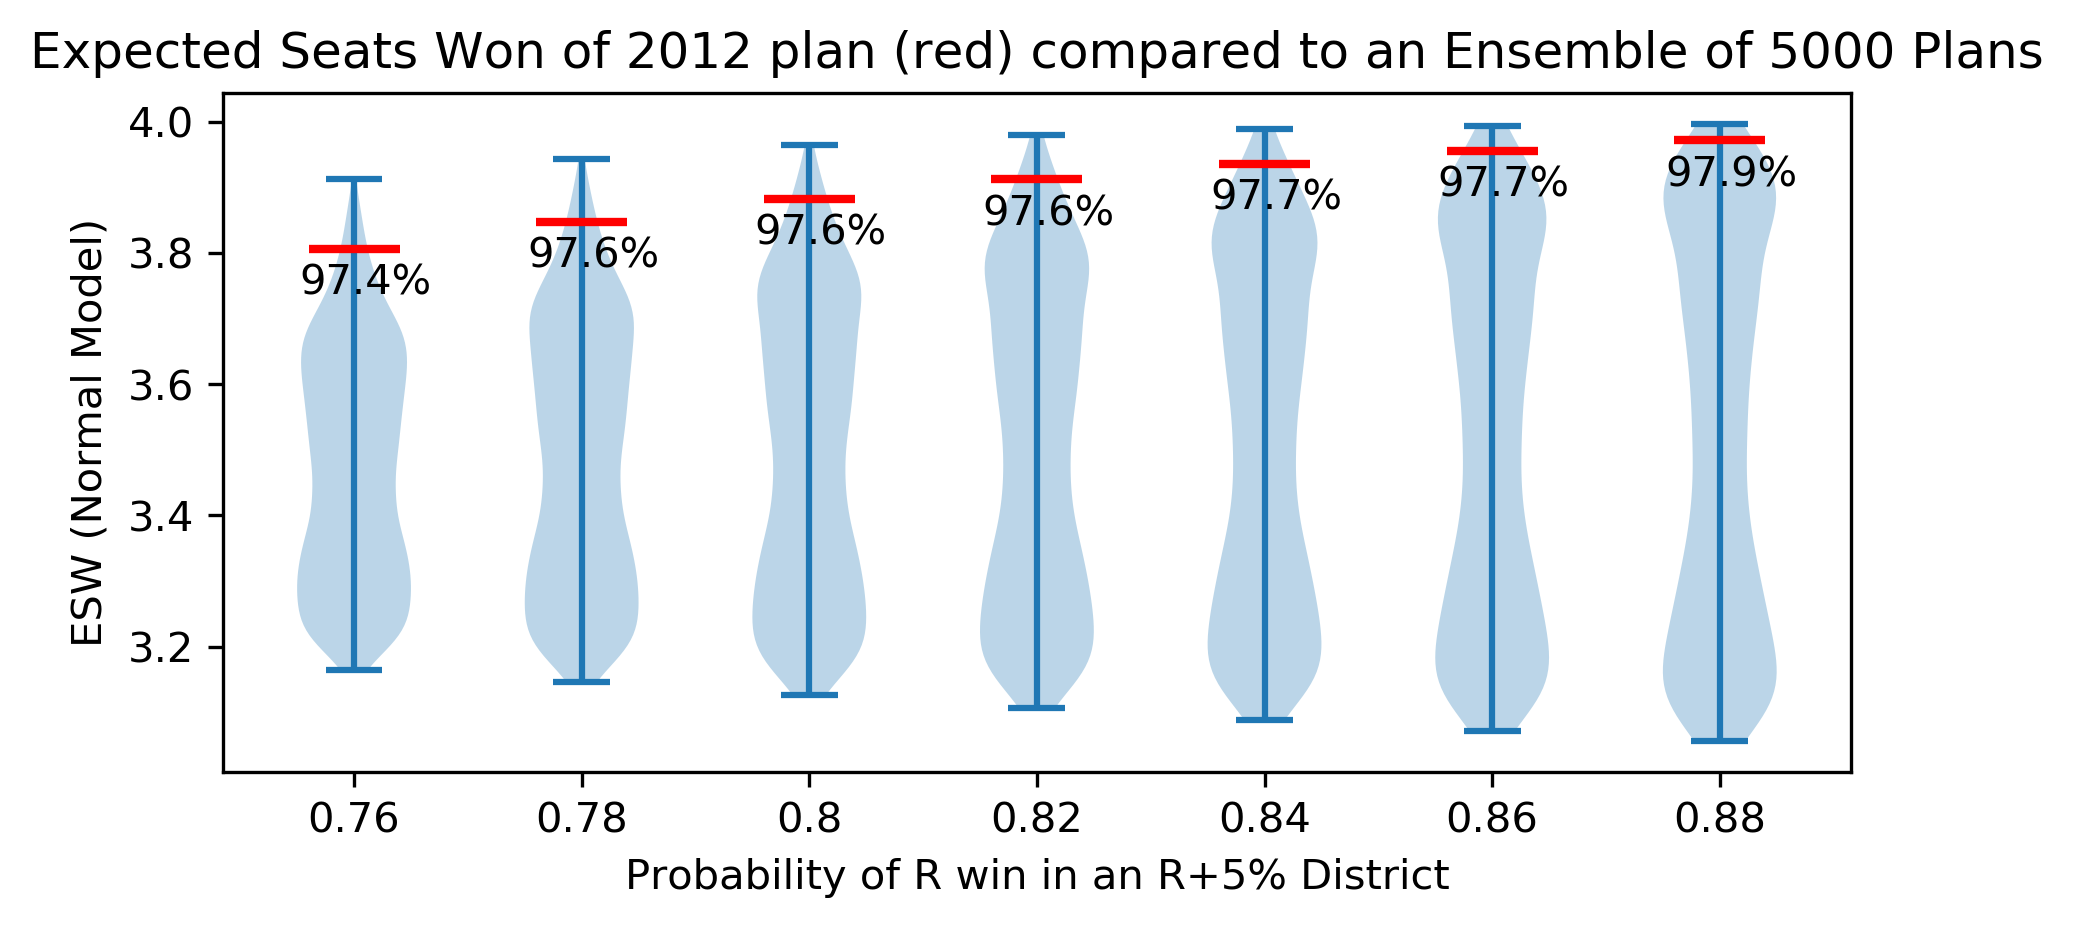

In [48]:
make_violin_plot_esw(esws2, probs2, mode="Normal", figsize=(7,3), save=True, savetitle="esw_normal_2")

In [49]:
# Make a violin plot for the beta distribution ESW
probs = 0.01*np.arange(65, 100, 5)

# Takes long (45 s)
# esws3 = pd.DataFrame([[esw_beta(s)(perc_rep.iloc[i]) for i in range(len(perc_rep))] for s in probs_to_ss(probs)])

# Use instead:
esws3 = pickle.load(open("esws3.pkl", 'rb'))

In [50]:
#pickle.dump(esws3, open("esws3.pkl", 'wb'))

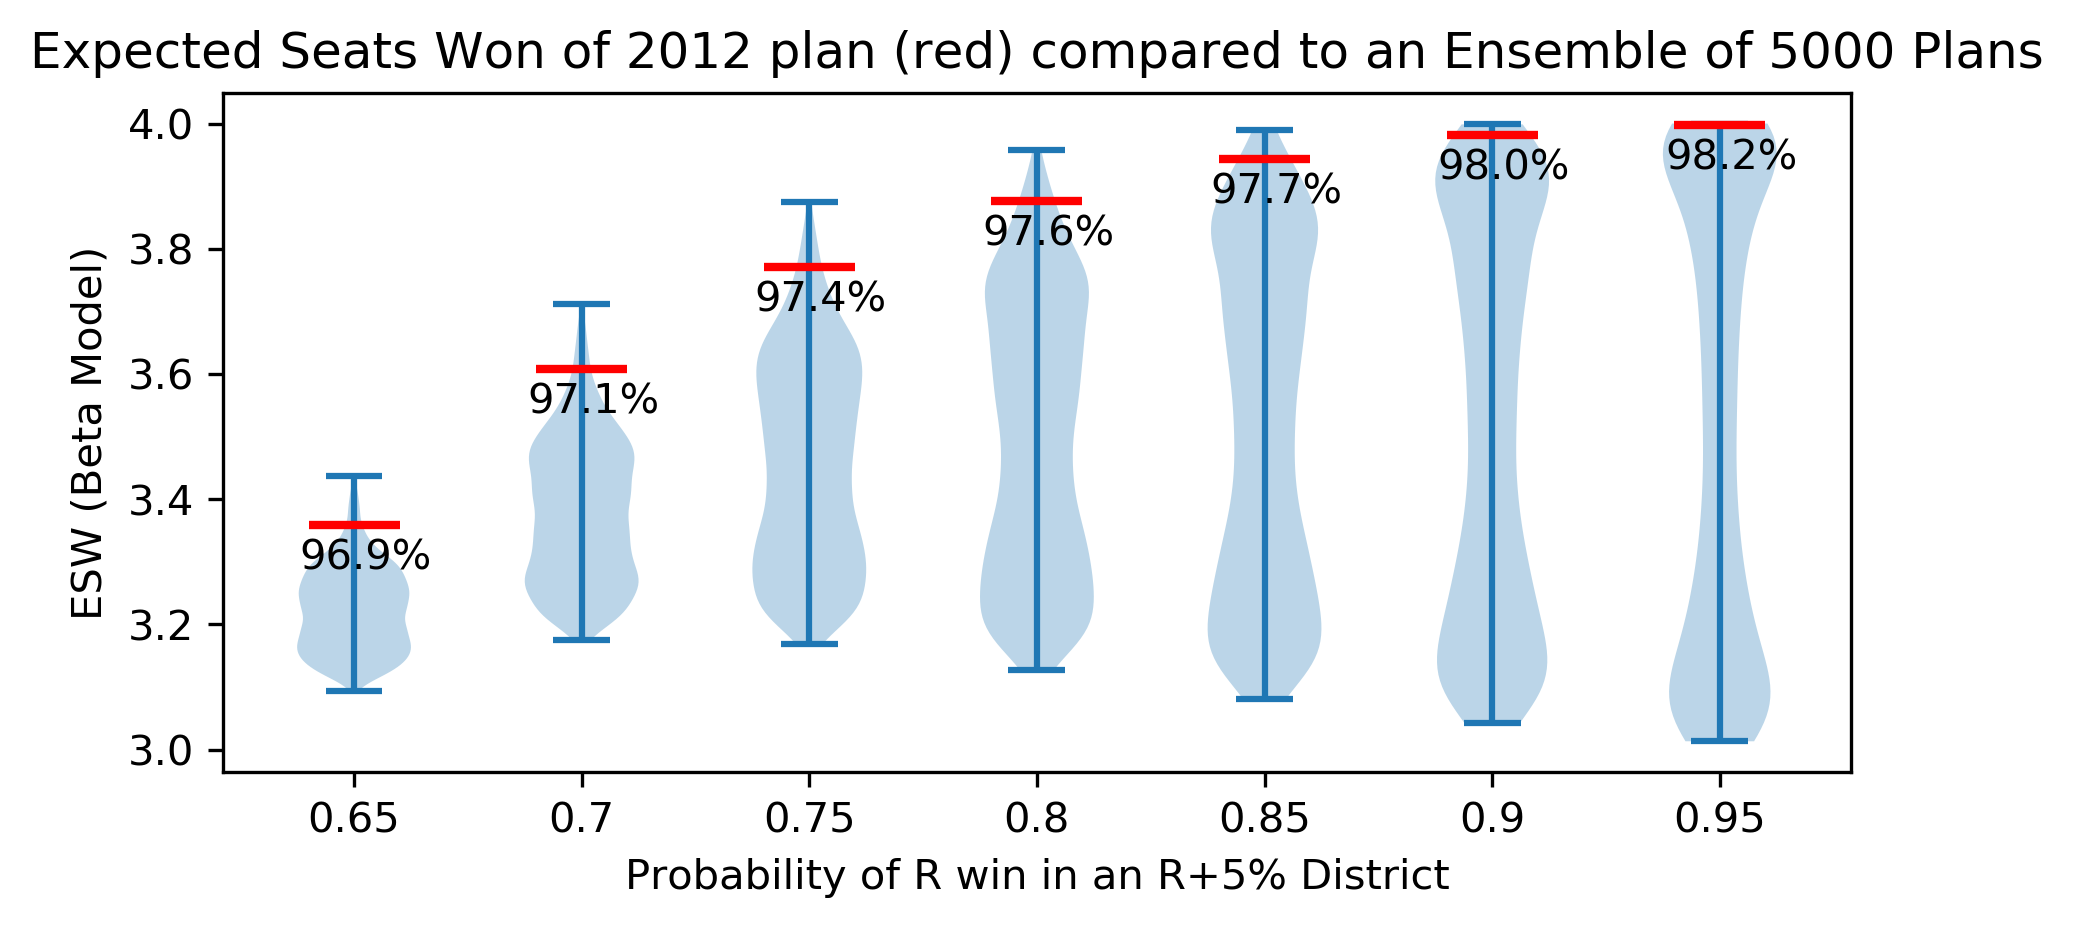

In [51]:
make_violin_plot_esw(esws3, probs, mode="Beta", figsize=(7,3), save=True, savetitle="esw_beta_1")

In [52]:
# Make a violin plot for the beta distribution ESW
probs2 = 0.01*np.arange(76, 90, 2)

# Takes Long (45 s)
# esws4 = pd.DataFrame([[esw_beta(s)(perc_rep.iloc[i]) for i in range(len(perc_rep))] for s in probs_to_ss(probs2)])

# Use instead:
esws4 = pickle.load(open("esws4.pkl", 'rb'))

In [53]:
# pickle.dump(esws4, open("esws4.pkl", 'wb'))

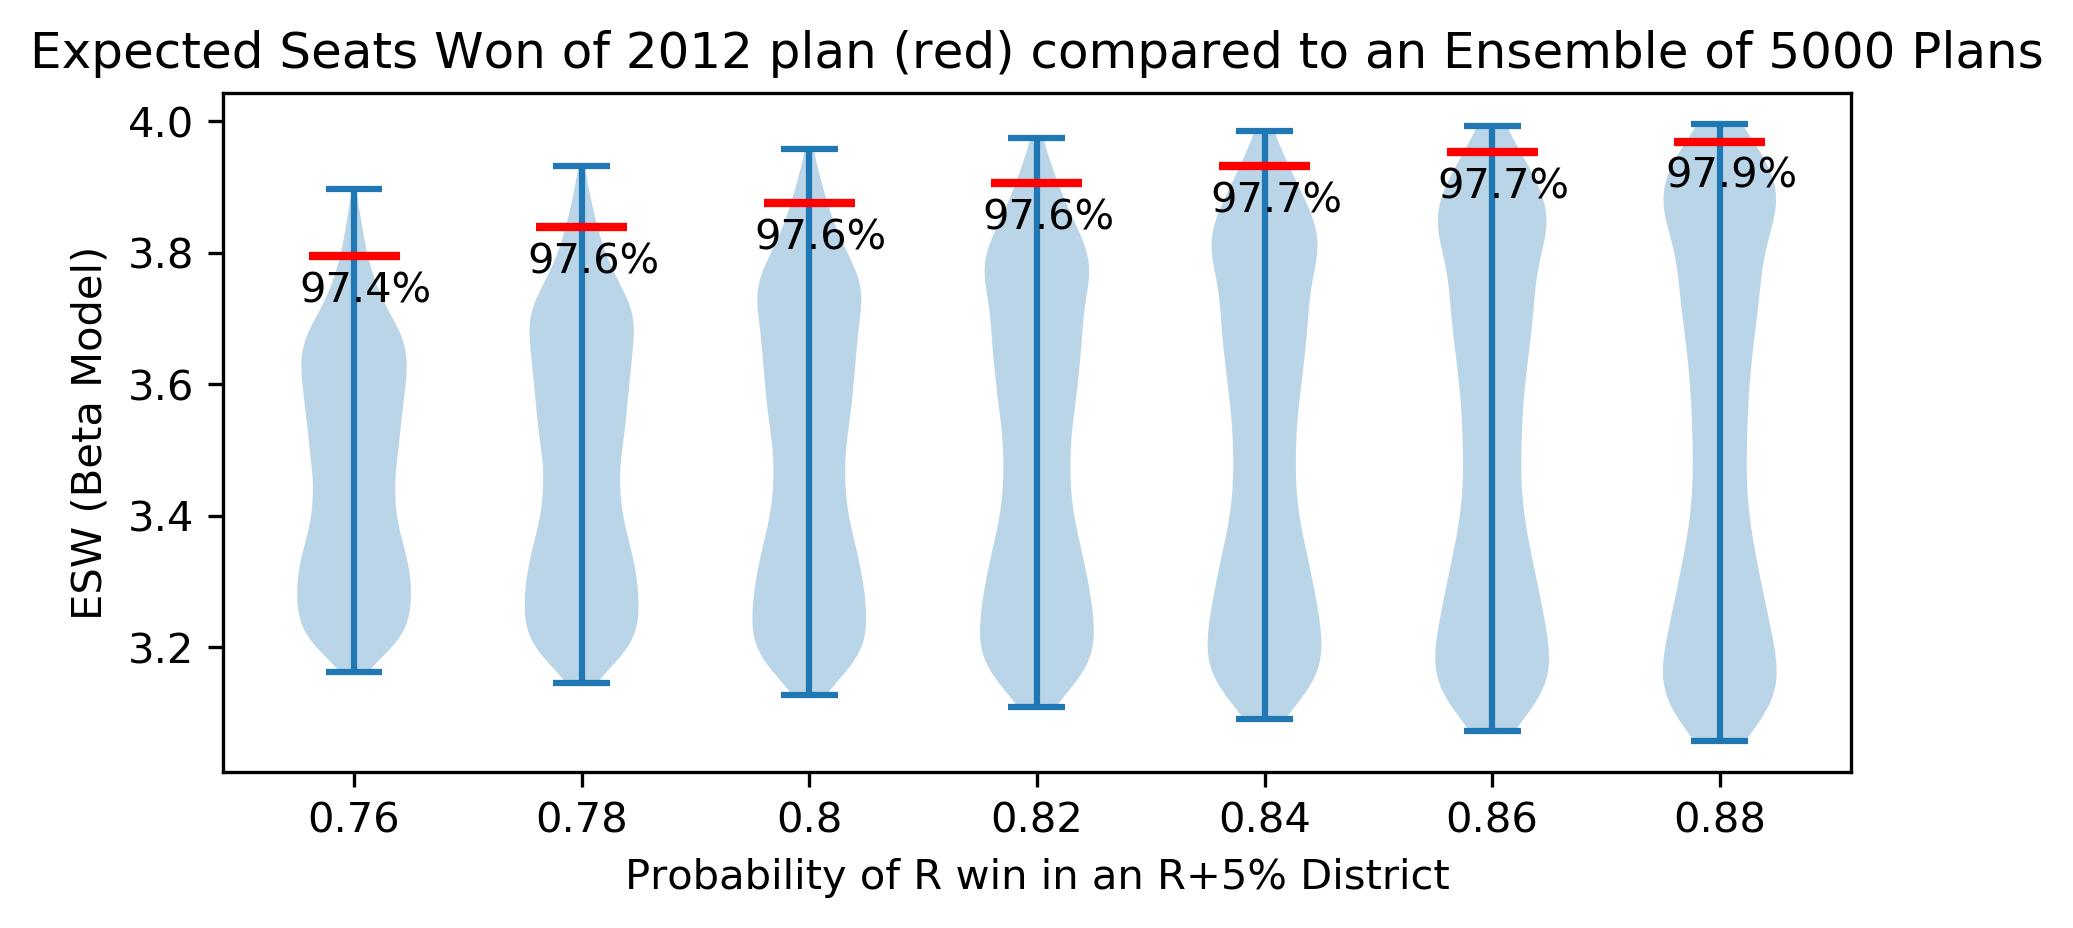

In [54]:
make_violin_plot_esw(esws4, probs2, mode="Beta", figsize=(7,3), save=True, savetitle="esw_beta_2")

In [55]:
range1 = probs_to_ss(np.array([0.95, 0.65]))

In [69]:
linspace1 = np.linspace(range1[0], range1[1], 50)

In [85]:
v = np.random.random(4)
print(v)
scores = np.array([esw_beta(s)(v) for s in linspace1])
print(np.max(scores)-np.min(scores))

[0.34745399 0.89037241 0.05485959 0.77791053]
0.10202462967040482


In [82]:
np.random.beta?

In [94]:
x = np.linspace(0, 1, 100)
y = x
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        v = np.array([X[i,j], Y[i, j]])
        scores = np.array([esw_beta(s)(v) for s in linspace1])
        Z[i, j] = np.max(scores) - np.min(scores)

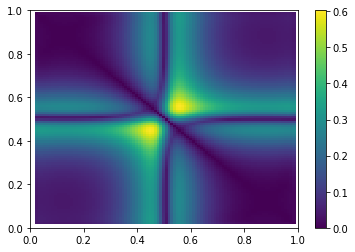

In [117]:
plt.pcolormesh(X, Y, Z)
plt.colorbar()
plt.show()

In [99]:
np.percentile(Z, 95)

nan

In [90]:
plt.pcolormesh?

In [116]:
np.percentile(Z, 50)

nan

np.count_nonzero(Z < 1)

In [109]:
False == 0

True